In [0]:
%matplotlib notebook

In [2]:
!pwd

/content


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("drive/My Drive/textcnn_updated/textcnn")

In [5]:
!ls

clean_data_abstract_ln_200.pkl	network.py
clean_data.txt			predictions-Copy1.ipynb
components.py			predictions.ipynb
dropout_layers.py		__pycache__
first_review.png		random.csv
glove.42B.300d.txt		random.gsheet
glove.42B.300d.txt.1		results_cnn_superclass.csv
linked_diseases_abstract.csv	text.txt
NCBI_corpus			Untitled.ipynb
NCBI_corpus.zip			utils
NCBItrainset.csv


In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9982707594600424704, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5603918539112737874
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17715906933600268379
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11276946637
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16998898359228876974
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
import csv,pandas,re
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding
from keras.layers import Embedding
import numpy as np
from keras.models import Model

import time, os
#os.environ["MKL_THREADING_LAYER"] = "GNU"
import components as com

# Torch imports
import torch
import torch.nn as nn
from torch import optim
import network as net
import traceback
from utils import tensor_utils as tu
import pickle

from tqdm import tqdm


import json
import requests
from pprint import pprint

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



device = torch.device("cuda")
cpu = torch.device("cpu")

Using TensorFlow backend.


In [0]:
debug = True
MAX_SEQUENCE_LENGTH = 200


class BadResponseException(Exception):
    pass


class Timer:
    """ Simple block which can be called as a context, to know the time of a block. """
    def __enter__(self):
        self.start = time.perf_counter()
        return self

    def __exit__(self, *args):
        self.end = time.perf_counter()
        self.interval = self.end - self.start

In [0]:
#data helpers - copied from https://github.com/bhaveshoswal/CNN-text-classification-keras
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ", string)
    string = re.sub(r"\)", " ", string)
    string = re.sub(r"\?", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def _get_class_for_doi_(doi:str) -> list:
    url = "http://id.nlm.nih.gov/mesh/sparql"
    query = """
                PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
                PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
                PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
                PREFIX owl: <http://www.w3.org/2002/07/owl#>
                PREFIX meshv: <http://id.nlm.nih.gov/mesh/vocab#>
                PREFIX mesh: <http://id.nlm.nih.gov/mesh/>
                PREFIX mesh2015: <http://id.nlm.nih.gov/mesh/2015/>
                PREFIX mesh2016: <http://id.nlm.nih.gov/mesh/2016/>
                PREFIX mesh2017: <http://id.nlm.nih.gov/mesh/2017/>
                PREFIX mesh2018: <http://id.nlm.nih.gov/mesh/2018/>
                PREFIX mesh2019: <http://id.nlm.nih.gov/mesh/2019/>
                SELECT DISTINCT ?p ?label ?uri 
                WHERE { mesh:%s meshv:broaderDescriptor* ?uri .
                    ?uri rdfs:label ?p.
                    FILTER NOT EXISTS{
                    ?uri meshv:broaderDescriptor ?x
                    }
                }
                """ % doi
    querystring = {"query":query, 'format':'json'}
    payload = ""
    headers = {
        'cache-control': "no-cache",
        'Postman-Token': "c9ace615-1b99-4caf-bcad-97ce1060973e"
        }

    response = requests.request("GET", url, data=payload, headers=headers, params=querystring)
    return [x['uri']['value'] for x in response.json()['results']['bindings']]


def get_classes_for_dois(dois:list) -> list:
    cls = []
    for doi in dois:
        cls += _get_class_for_doi_(doi)
    
    return list(set(cls))

In [0]:
def get_terms_of_classes(list_terms) -> list:
    url = "http://id.nlm.nih.gov/mesh/sparql"
    query = """
            PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
            PREFIX owl: <http://www.w3.org/2002/07/owl#>
            PREFIX meshv: <http://id.nlm.nih.gov/mesh/vocab#>
            PREFIX mesh: <http://id.nlm.nih.gov/mesh/>
            PREFIX mesh2015: <http://id.nlm.nih.gov/mesh/2015/>
            PREFIX mesh2016: <http://id.nlm.nih.gov/mesh/2016/>
            PREFIX mesh2017: <http://id.nlm.nih.gov/mesh/2017/>
            PREFIX mesh2018: <http://id.nlm.nih.gov/mesh/2018/>
            PREFIX mesh2019: <http://id.nlm.nih.gov/mesh/2019/>
            SELECT DISTINCT ?class
            WHERE { mesh:%s rdfs:label ?class . }
            """%list_terms
    querystring = {"query":query, 'format':'json'}
    payload = ""
    headers = {
        'cache-control': "no-cache",
        'Postman-Token': "c9ace615-1b99-4caf-bcad-97ce1060973e"
        }

    response = requests.request("GET", url, data=payload, headers=headers, params=querystring)
    return [x['class']['value'] for x in response.json()['results']['bindings']]
        

In [0]:
def get_list_for_terms(dois:list) -> list:
    cls = []
    for doi in dois:
        cls += get_terms_of_classes(doi.replace("http://id.nlm.nih.gov/mesh/", ""))
    
    return list(set(cls))

In [0]:

df = pandas.read_csv('linked_diseases_abstract.csv')
data = [x for x in df.to_records(index=False)] 
def read_till_next(data,index):
    temp = []
    temp_loc = 0
    for d in data[index+1:]:
        if 'a' in d[1] or 't' in d[1]:
            return temp,temp_loc
        else:
            temp_loc = temp_loc + 1
            temp.append([d[2],d[3],d[4]])
#             print([d[2],d[3],d[4]])
#             break
    
    return temp,temp_loc

loc = 0
final_data = []
for index,d in enumerate(data):
    if '|t|' in d[1]:
        continue
    elif loc != 0:
        loc = loc - 1
        continue
    else:
        if '|a|' in d[1]:
            temp_holder = {
                'abstract' : d[1],
                'keys' : []
            }
            keys,loc = read_till_next(data,index)
            temp_holder['keys'] = keys
            final_data.append(temp_holder)
clean_data = []
for f in final_data:
    abstarct = clean_str(f['abstract'].split('|')[2])
    disease = []
    for k in f['keys']:
        disease.append(k[-1])
    clean_data.append((abstarct,list(set(disease))))

In [0]:
#Now changing the hiearchy of the diseases dataset where we only consider Diseases ontology 
clean_data_upper_class = []
us = []
for c in tqdm(clean_data):
    try:
        labels = []
        for l in c[1]:
            if 'D' == l[0]:
                labels = labels + l.split("|")
        #change the class hiearchy 
        new_labels = list(set(get_classes_for_dois(labels)))
        clean_data_upper_class.append((c[0],new_labels))
    except:
        us.append(c)

clean_data = clean_data_upper_class

100%|██████████| 793/793 [07:41<00:00,  1.34it/s]


In [0]:
targets = [tar[1] for tar in clean_data]

In [0]:
with open ('clean_data_abstract_ln_200.pkl', 'rb') as fp:
  clean_data = pickle.load(fp)

In [0]:
clean_data[0]

('wnt signalling orchestrates a number of developmental programs in response to this stimulus , cytoplasmic beta catenin encoded by ctnnb1 is stabilized , enabling downstream transcriptional activation by members of the lef tcf family one of the target genes for beta catenin tcf encodes c myc , explaining why constitutive activation of the wnt pathway can lead to cancer , particularly in the colon most colon cancers arise from mutations in the gene encoding adenomatous polyposis coli apc , a protein required for ubiquitin mediated degradation of beta catenin , but a small percentage of colon and some other cancers harbour beta catenin stabilizing mutations recently , we discovered that transgenic mice expressing an activated beta catenin are predisposed to developing skin tumours resembling pilomatricomas given that the skin of these adult mice also exhibits signs of de novo hair follicle morphogenesis , we wondered whether human pilomatricomas might originate from hair matrix cells an

In [0]:
#creating id map of class that is each label is given a unique id
all_class = list(set([g for f in clean_data for g in f[1]]))
all_class_to_id = {}
for index,value in enumerate(all_class):
    all_class_to_id[value] = index

texts = [f[0] for f in clean_data]

#Tokenize,idfy,pad
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = MAX_SEQUENCE_LENGTH)
training_data = vectorizer.fit_transform(texts)
print(training_data.shape)

(774, 200)


In [0]:
ids = []
for i in all_class:
    ids.append(i.replace("http://id.nlm.nih.gov/mesh/", ""))
list_ids=pandas.DataFrame(ids)

In [0]:
targets = get_list_for_terms(all_class)

In [0]:
print(data[0].shape)
print(training_data[0].shape)

(200,)
(1, 200)


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

Cvectorizer = CountVectorizer(max_features = MAX_SEQUENCE_LENGTH)
train_data = Cvectorizer.fit_transform(texts)
print(train_data.shape)

(774, 200)


In [16]:
#constructing the label matrix 
label_matrix = np.zeros((len(all_class),len(all_class)))
for index,value in enumerate(all_class):
    label_matrix[index][index] = 1
    
#Testing 
label_matrix[all_class_to_id[all_class[1]]]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def create_multi_hot_label(label_matrix,labels):
    '''
    
        label_matrix --> matrix having one hot vectors
        labels --> [idfy]--> [2,5,6]
        return [0,0,1,0,0,1....]
    '''
    vector = np.zeros((label_matrix.shape[0]))
    for i in labels:
        vector = vector + label_matrix[all_class_to_id[all_class[i]]]
    
    return vector

In [0]:
label_vector = []
for f in clean_data:
    label_id = [all_class_to_id[l] for l in f[1]]
    multi_hot_vector = create_multi_hot_label(label_matrix,label_id)
    label_vector.append(multi_hot_vector)

In [0]:
X = data
Y = label_vector
split_index = int(len(X)*.80)
train_x,val_x = X[:split_index],X[split_index:]
train_y,val_y = Y[:split_index],Y[split_index:]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [0]:
print(X_train)

In [20]:
!pip install scikit-multilearn


    100% |████████████████████████████████| 92kB 5.4MB/s 


In [0]:
from skmultilearn.cluster import NetworkXLabelGraphClusterer

# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

In [0]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')

In [26]:
partition = clusterer.fit_predict(np.asarray(train_x), np.asarray(train_y))
partition


array([list([0, 1, 13, 18, 28, 30, 31, 34, 42, 45, 46, 47]),
       list([2, 5, 9, 12, 15, 16, 25, 29, 35, 36]),
       list([3, 4, 6, 7, 8, 11, 14, 17, 19, 21, 22, 24, 26, 27, 32, 37, 38, 40, 43, 44]),
       list([10, 20, 23, 33, 39, 41])], dtype=object)

In [0]:
membership_vector = to_membership_vector(partition)

In [0]:
import networkx as nx
names_dict = dict(enumerate(x.replace('-','-\n') for x in targets))

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


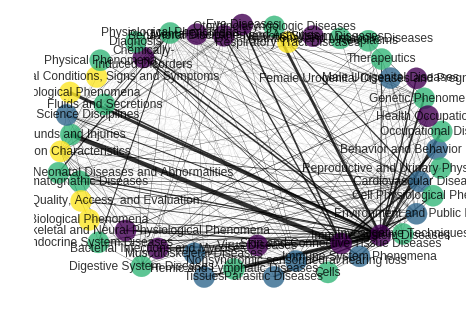

In [46]:
nx.draw(
    clusterer.graph_,
    pos=nx.spring_layout(clusterer.graph_, k=48),
    labels=names_dict,
    with_labels = True,
    width = [10*x/(np.asarray(train_y)).shape[0] for x in clusterer.weights_['weight']],
    node_color = [membership_vector[i] for i in range(np.asarray(train_y).shape[1])],
    cmap=plt.cm.viridis,
    node_size=450,
    font_size=12,
    font_color='black',
    alpha=0.8

)

In [0]:
!pip install yellowbrick

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

from wordcloud import WordCloud,STOPWORDS
import seaborn as sns

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
#printmd('**bold**')

plt.figure(figsize=(40,25))
# clean

#text = subset.comment_text.values
cloud_abstracts = WordCloud(max_font_size=50,
                            max_words = len(texts),
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=1800,
                          height=1300
                         ).generate(" ".join(texts))
#plt.figure()

#plt.title("Abstracts",fontsize=30)
plt.imshow(cloud_abstracts)#, interpolation='bilinear')
plt.axis('off')
plt.show()

#cloud_abstracts.to_file("first_review.png")

# Same code can be used to generate wordclouds of other categories.

In [0]:
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC, NuSVC
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
#from yellowbrick.classifier import ClassPredictionError
#from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

#parameters = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}
#score = 'accuracy' #, 'hamming_loss', 'precision_score_weighted'

#classifier = GridSearchCV(MLkNN(), parameters, scoring=score)

#X_train, X_test, y_train, y_test

#classifier = ClassifierChain(LinearSVC())
#classifier = LabelPowerset(LinearSVC())
#classifier = BinaryRelevance(NuSVC())

#classifier = BinaryRelevance(MLPClassifier())
#classifier = ClassifierChain(MLPClassifier())

classifier = BinaryRelevance(RandomForestClassifier())
#classifier = BinaryRelevance(DecisionTreeClassifier())
#classifier = BinaryRelevance(MLPClassifier())
#classifier = LabelPowerset(MLkNN())

#classifier = MLkNN(k=20)
#classifier = ClassifierChain(GradientBoostingClassifier())

classifier.fit(X_train, np.asarray(y_train))
predictions = classifier.predict(X_test)

#classifier.score(np.asarray(val_y),predictions)
#classifier.poof
#model_selection(X, Y, LinearSVC())

print(accuracy_score(np.asarray(y_test),predictions))
print(hamming_loss(np.asarray(y_test),predictions))
print(f1_score(np.asarray(y_test),predictions, average = 'weighted'))
print(precision_score(np.asarray(y_test),predictions, average = 'weighted'))

# print (classifier., classifier.best_score_)
# sorted(classifier.cv_results_.keys()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

0.16774193548387098
0.0489247311827957
0.6048810411350333
0.8159867517564439


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets




In [0]:
X_train

<619x200 sparse matrix of type '<class 'numpy.float64'>'
	with 26766 stored elements in Compressed Sparse Row format>

In [0]:
vecs = np.random.randn(len(word_index),300)
embeddings_index = {}
f = open('glove.42B.300d.txt.2', encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))




Found 1917494 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
vecs = embedding_matrix

In [0]:
train_data = {
    'x' : train_x,
    'y': np.asarray(train_y)
}

valid_data = {
    'x' : val_x,
    'y' : np.asarray(val_y)
}

train_fact_iter = SimplestSampler(train_data)
valid_fact_iter = SimplestSampler(valid_data)

In [0]:
for dat in train_fact_iter:
    break
dat[0].shape, dat[1].shape

((64, 200), (64, 48))

In [0]:

_x = torch.tensor(dat[0], dtype=torch.long, device=device)
_y = torch.tensor(dat[1], dtype=torch.long, device=device)

data = {
    'sent_batch' : _x,
    'y_label' : _y
}

loss = modeler.train(data, optimizer, loss_fn, device)
op = modeler.predict(_x,device)

torch.Size([64, 619])


In [0]:
len(op)

64

In [0]:
loss

NameError: ignored

In [0]:
val_data =  tokenizer.sequences_to_texts(val_x)

In [0]:
predictions = [get_predictions_given_text(data_points) for index, data_points in enumerate(val_data)]

In [0]:
for dat_val in valid_fact_iter:
    break
dat_val[0].shape, dat_val[1].shape

((64, 200), (64, 48))

In [0]:
new_labels

['http://id.nlm.nih.gov/mesh/D052801',
 'http://id.nlm.nih.gov/mesh/D009358',
 'http://id.nlm.nih.gov/mesh/D017437',
 'http://id.nlm.nih.gov/mesh/D004700',
 'http://id.nlm.nih.gov/mesh/D009369',
 'http://id.nlm.nih.gov/mesh/D005261']

In [0]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\stuti.nayak\AppData\Local\Continuum\Anaconda3\envs\metawiz-keras-theano\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
